# CNN для сентимент-анализа
### Используем CNN для классификации отзывов с IMDB по эмоциональной окраске. 

In [1]:
import re
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import numpy.random

from keras.datasets import imdb
from sklearn.metrics import f1_score
from keras.preprocessing import sequence

%matplotlib inline
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

max_features = 5000
maxlen = 400
batch_size = 50
embedding_dims = 50
n_filters = 250
kernel_size = 3
hidden_dims = 250
learning_rate = 0.001
training_steps = 2
width = 3

Using TensorFlow backend.


### Создадим подмножества выборок на 20%, 40%, 60%, 80% и 100%:

In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

#x_ses = [x_train, x_train[int(len(x_train)*0.8):], x_train[int(len(x_train)*0.6):], x_train[int(len(x_train)*0.4):],
#         x_train[int(len(x_train)*0.2):]]

x_1 = x_train[int(len(x_train)*0.2):]
x_2 = x_train[int(len(x_train)*0.4):]
x_3 = x_train[int(len(x_train)*0.6):]
x_4 = x_train[int(len(x_train)*0.8):]
x_5 = x_train

x_1_test = x_test[int(len(x_test)*0.2):]
x_2_test = x_test[int(len(x_test)*0.4):]
x_3_test = x_test[int(len(x_test)*0.6):]
x_4_test = x_test[int(len(x_test)*0.8):]
x_5_test = x_test

#y_s = [y_train, y_train[int(len(x_train)*0.8):], y_train[int(len(x_train)*0.6):], x_train[int(len(x_train)*0.4):],
#         x_train[int(len(x_train)*0.2):]]

y_1 = y_train[int(len(y_train)*0.2):]
y_2 = y_train[int(len(y_train)*0.4):]
y_3 = y_train[int(len(y_train)*0.6):]
y_4 = y_train[int(len(y_train)*0.8):]
y_5 = y_train

y_1_test = y_test[int(len(y_test)*0.2):]
y_2_test = y_test[int(len(y_test)*0.4):]
y_3_test = y_test[int(len(y_test)*0.6):]
y_4_test = y_test[int(len(y_test)*0.8):]
y_5_test = y_test

print('Pad sequences (samples x time)')

#x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

x_1 = sequence.pad_sequences(x_1, maxlen=maxlen)
x_2 = sequence.pad_sequences(x_2, maxlen=maxlen)
x_3 = sequence.pad_sequences(x_3, maxlen=maxlen)
x_4 = sequence.pad_sequences(x_4, maxlen=maxlen)
x_5 = sequence.pad_sequences(x_5, maxlen=maxlen)

x_1_test = sequence.pad_sequences(x_1_test, maxlen=maxlen)
x_2_test = sequence.pad_sequences(x_2_test, maxlen=maxlen)
x_3_test= sequence.pad_sequences(x_3_test, maxlen=maxlen)
x_4_test = sequence.pad_sequences(x_4_test, maxlen=maxlen)
x_5_test = sequence.pad_sequences(x_5_test, maxlen=maxlen)


x_trains = [x_1, x_2, x_3, x_4, x_5]
x_tests = [x_1_test, x_2_test, x_3_test, x_4_test, x_5_test]
y_trains = [y_1, y_2, y_3, y_4, y_5]
y_tests = [y_1_test, y_2_test, y_3_test, y_4_test, y_5_test]

x_trains.sort(key = len)
x_tests.sort(key = len)
y_trains.sort(key = len)
y_tests.sort(key = len)

#print('x_train shape:', x_train.shape)
#print('x_test shape:', x_test.shape)


25000 train sequences
25000 test sequences
Pad sequences (samples x time)


In [5]:
X = tf.placeholder("int32", [batch_size, maxlen])
Y = tf.placeholder("float32", [batch_size,]) 

In [6]:
xavier_init = tf.contrib.layers.xavier_initializer()
word_embs  = tf.Variable(xavier_init([max_features, embedding_dims]))
xavier_init = tf.contrib.layers.xavier_initializer()
filters = tf.Variable(xavier_init([width, embedding_dims, n_filters]))

In [7]:
def neural_net(x):
    #print(tf.shape(x))
    
    x = tf.nn.embedding_lookup(word_embs, x) #embedding - returns batch x len x emb ????
    #print(tf.shape(x))
    x = tf.layers.dropout(inputs = x, rate = 0.2)
    #print(x.dtype)
    x = tf.nn.conv1d(value=x, filters = filters, stride = 1,padding = 'VALID')
    x = tf.nn.relu(features = x)
    #print(tf.shape(x))
    x = tf.layers.max_pooling1d(inputs = x, pool_size = maxlen - 2, strides = 1, padding = 'VALID') #pool_size = tf.shape(x)[1]
    #print(tf.shape(x))
    x = tf.squeeze(x, [1]) #because of one fictional dim from global max pooling
    x = tf.layers.dense(inputs = x, units = 250, activation = 'relu') #has his variables inside?
    x = tf.layers.dropout(inputs = x, rate = 0.2)
    #print(tf.shape(x))
    x = tf.layers.dense(inputs = x, units = 1)
    #x = tf.nn.sigmoid(x)
    #print(tf.shape(x))
    return x

In [8]:
logits = tf.squeeze(neural_net(X), [1])

#this WAS in LSTM. needed? 
prediction_sm = tf.nn.sigmoid(logits) # THIS IS THE ANSWER ALREADY


# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=Y)) #there is softmax applied to the last output
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

correct_pred = tf.equal(prediction_sm, Y)#tf.argmax(logits, 1),

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

### Обучим и протестируем модель на каждом из подмножеств, выводя средний loss на 50 батчах:

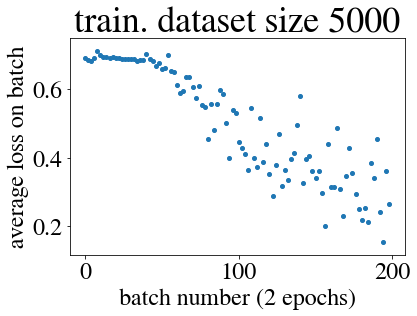

F1 score is [0.8326369  0.86044379] for test dataset size 5000


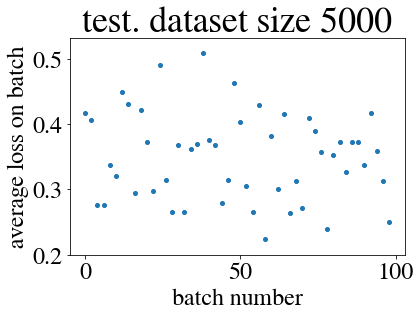

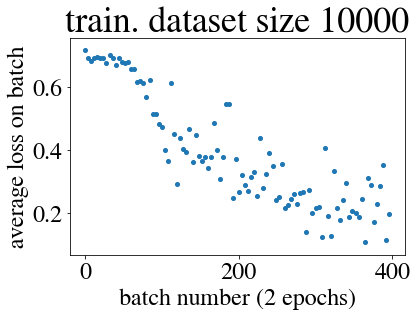

F1 score is [0.87002761 0.87564818] for test dataset size 10000


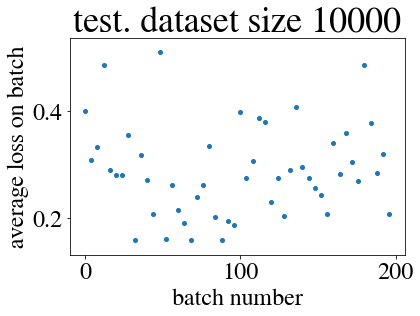

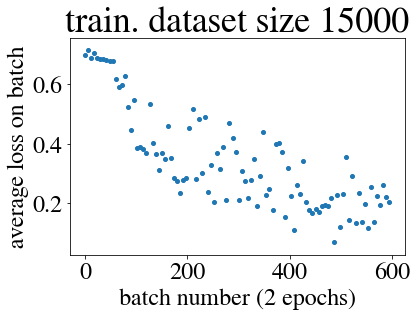

F1 score is [0.87820249 0.88456045] for test dataset size 15000


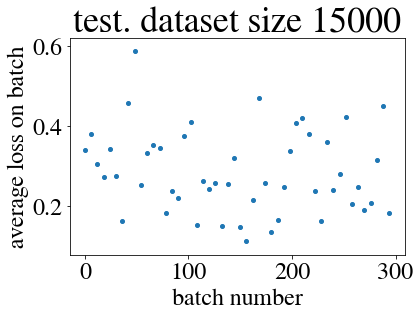

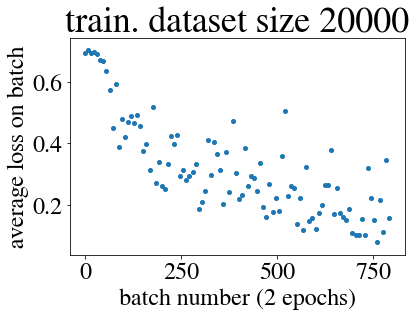

F1 score is [0.86918966 0.88718164] for test dataset size 20000


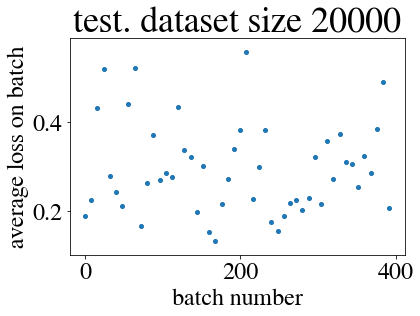

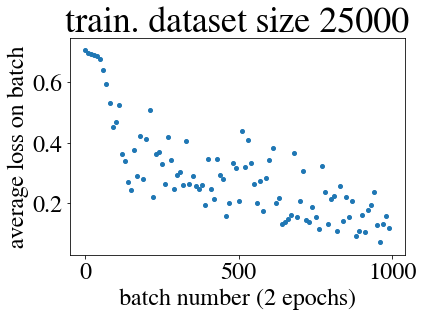

F1 score is [0.88275517 0.89191267] for test dataset size 25000


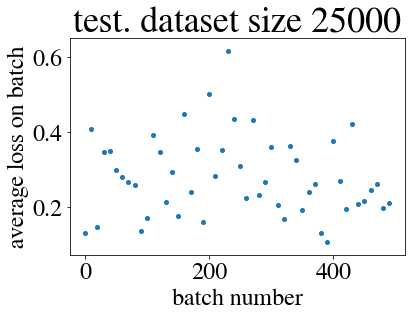

In [12]:


for ii in range(len(x_trains)):
    with tf.Session() as sess:
        sess.run(init)


        #print(len(x_trains[ii]), len(y_trains[ii]), len(x_tests[ii]))
        num_dots = 50
        division = (len(x_tests[ii])//batch_size)//num_dots
        y = []
        for step in range(1, training_steps+1):
            i = 0
            #while i*batch_size < len(x_train):
            while i*batch_size < len(x_trains[ii]):

                x_batch, y_batch = x_trains[ii][i*batch_size:(i+1)*batch_size], y_trains[ii][i*batch_size:(i+1)*batch_size]
                i += 1
                #print(i, x_batch.shape, y_batch.shape)

                _, loss_ = sess.run([train_op, loss], feed_dict={X: x_batch, Y: y_batch}) 
                if i % division == 0:
                    y.append(loss_)

        plt.scatter(x = range(0, division*len(y), division), y = y)
        plt.xlabel("batch number (2 epochs)")
        plt.ylabel("average loss on batch")
        plt.title("train. dataset size "+str(len(x_trains[ii])))
        plt.show()
        
        prediction = np.array([])

        i = 0
        y = []
        
        while i*batch_size < len(x_tests[ii]):
            x_batch, y_batch = x_tests[ii][i*batch_size:(i+1)*batch_size], y_tests[ii][i*batch_size:(i+1)*batch_size]
            i += 1


            a, loss_ = sess.run([prediction_sm, loss], feed_dict={X: x_batch, Y: y_batch})
            #print(a,t)
            prediction = np.append(prediction, np.asarray(a))
            if i % division == 0:
                y.append(loss_)
        
        prediction = [int(round(t)) for t in prediction]
        F1 = f1_score(y_true=y_tests[ii], y_pred=prediction, average=None)
        print("F1 score is", F1, "for test dataset size", len(x_tests[ii])) 
        plt.scatter(x = range(0, division*len(y), division), y = y)
        plt.xlabel("batch number")
        plt.ylabel("average loss on batch")
        plt.title("test. dataset size "+str(len(x_tests[ii])))
        plt.show()
        sess.close()



### В этом датасете слова кодируются своими индексами, упорядоченными по частоте встречаемости слов. Чтобы внести шум, сложим индексы с равномерно распределенными целыми числами в заданных пределах. Обучим модель на трех шумах, так же выводя средний loss на 50-ти батчах.

In [22]:
noise_1 = numpy.random.randint(-1, 1, (25000, 400))
noise_2 = numpy.random.randint(-3, 3, (25000, 400))
noise_3 = numpy.random.randint(-5, 5, (25000, 400))

x_trains = []
x_tests = []
y_trains = [y_train, y_train, y_train]
y_tests = [y_test, y_test, y_test]

x_train = np.asarray(sequence.pad_sequences(x_train, maxlen=maxlen))
x_test = np.asarray(sequence.pad_sequences(x_test, maxlen=maxlen))

x_train_noisy_1 = x_train + noise_1
x_test_noisy_1 = x_test + noise_1
x_trains.append(x_train_noisy_1.clip(0, max_features-1))
x_tests.append(x_test_noisy_1.clip(0, max_features-1))

x_train_noisy_2 = x_train + noise_2
x_test_noisy_2 = x_test + noise_2
x_trains.append(x_train_noisy_2.clip(0, max_features-1))
x_tests.append(x_test_noisy_2.clip(0, max_features-1))

x_train_noisy_3 = x_train + noise_3
x_test_noisy_3 = x_test + noise_3
x_trains.append(x_train_noisy_3.clip(0, max_features-1))
x_tests.append(x_test_noisy_3.clip(0, max_features-1))

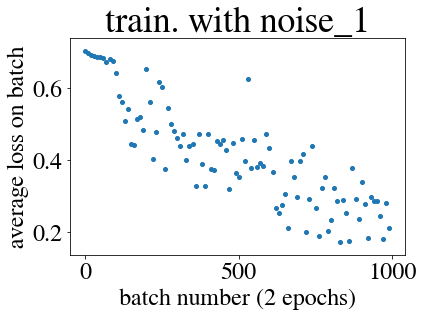

F1 score is [0.82695521 0.84108349] with noise_1


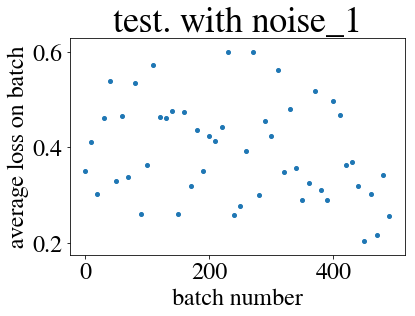

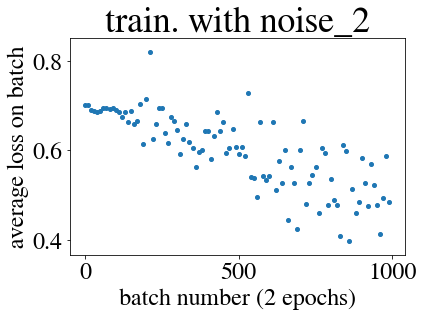

F1 score is [0.68243243 0.72099489] with noise_2


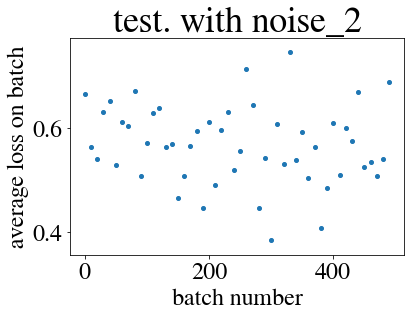

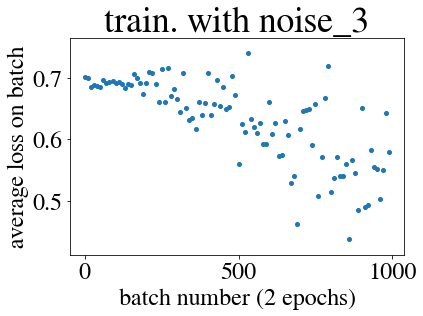

F1 score is [0.63615129 0.65312341] with noise_3


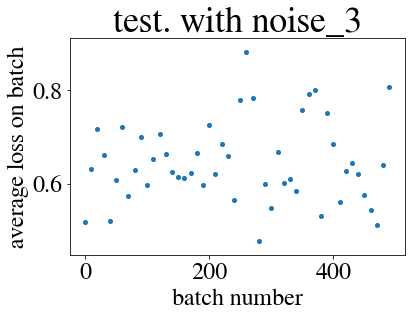

In [23]:
for ii in range(len(x_trains)):
    with tf.Session() as sess:
        sess.run(init)
        num_dots = 50
        division = (len(x_tests[ii])//batch_size)//num_dots

        #print(len(x_trains[ii]), len(y_trains[ii]), len(x_tests[ii]))

        y = []
        for step in range(1, training_steps+1):
            i = 0
            #while i*batch_size < len(x_train):
            while i*batch_size < len(x_trains[ii]):

                x_batch, y_batch = x_trains[ii][i*batch_size:(i+1)*batch_size], y_trains[ii][i*batch_size:(i+1)*batch_size]
                i += 1
                #print(i, x_batch.shape, y_batch.shape)

                _, loss_ = sess.run([train_op, loss], feed_dict={X: x_batch, Y: y_batch}) 
                if i % division == 0:
                    y.append(loss_)

        plt.scatter(x = range(0, division*len(y), division), y = y)
        plt.xlabel("batch number (2 epochs)")
        plt.ylabel("average loss on batch")
        plt.title("train. with noise_"+str(ii+1))
        plt.show()
        
        prediction = np.array([])

        i = 0
        y = []
        while i*batch_size < len(x_tests[ii]):
            x_batch, y_batch = x_tests[ii][i*batch_size:(i+1)*batch_size], y_tests[ii][i*batch_size:(i+1)*batch_size]
            i += 1


            a, loss_ = sess.run([prediction_sm, loss], feed_dict={X: x_batch, Y: y_batch})
            #print(a,t)
            prediction = np.append(prediction, np.asarray(a))
            if i % division == 0:
                y.append(loss_)
        
        prediction = [int(round(t)) for t in prediction]
        F1 = f1_score(y_true=y_tests[ii], y_pred=prediction, average=None)
        print("F1 score is", F1, "with noise_"+str(ii+1))
        plt.scatter(x = range(0, division*len(y), division), y = y)
        plt.xlabel("batch number")
        plt.ylabel("average loss on batch")
        plt.title("test. with noise_"+str(ii+1))
        plt.show()
        sess.close()

